* MNIST inverse network
* Newsgroups inverse network
* Squared error loss and classification loss
  * Also with L1 regularisation
* https://papers.nips.cc/paper/119-skeletonization-a-technique-for-trimming-the-fat-from-a-network-via-relevance-assessment.pdf

----

Yann Lecun's paper "Optimal Brain Damage":
* This is a paper on network pruning (not our primary focus)
* Let's use a Taylor series to calculate $\delta E$ based on a perturbation of the parameter vector $U$, $\delta U$. **This formulation is slightly confusing for me, because it's not expressing the effect on $E$ by perturbing a single weight value $u_i$, but a weight vector $U$.**
* We assume that $\frac{\partial E}{\partial u_{i}} = 0$ (i.e. each weight is at a local minimum), but this seems to imply that training is finished, and that we prune the network after training. **It seems like a waste because we have to wait until the network is fully trained to start pruning it.**
* Assumes the cost function is nearly quadratic
* Use a simplification of the Hessian $\frac{\partial^{2} E}{\partial u_{i} \partial u_{j}} = \frac{\partial}{\partial u_{j}} \Big( \frac{\partial E}{\partial u_{i}} \Big)$ by taking the diagonal elements and use that.
* The saliency of each parameter $s_{k} = h_{kk}u^{2}_{k} / 2$
* I feel as though the computation of $\frac{\partial E}{\partial u_{i}}$ is more straightforward. **This doesn't require computation of the Hessian (even though LeCun only does the diagonal of the Hessian).**

Mozer and Smolensky paper on "Skeletonisation":
* This is a paper on network pruning (again, not our primary focus)
* Let the output of a hidden unit $o_{j} = sigm(\sum_{i} w_{ji} \alpha_{i} o_{i})$
* The $\alpha_{i}$ is a "gating unit" that is always equal to 1, but we can compute $\frac{\partial E}{\partial o_{i}}$ instead to see how the loss changes when we decrease the "significance" of that unit
* **They say this technique is poor when the output is close to the target but this could be mitigated by using a validation set?**

My work:

* Use the validation set to do smart re-init of weights
* Compute the average of $|\frac{\partial E}{\partial h_{i}}|$ over the entire validation set to get an unbiased measure of how sensitive each hidden unit $h_{i}$ is to the loss function.
* Also compute the average of $|\frac{\partial E}{\partial x_{i}}|$ on the validation set to get a ranking of how well each input feature does.
* ##What happens if we do LeCun styles and prune the network after training using the validation set?

In [1]:
import sys
import cPickle as pickle
import gzip
import random
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../modules/")
import helper as hp
# ----
import theano
from theano import tensor as T
import lasagne
import numpy as np
# ---
from skimage import io
# ---
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.init import *
from lasagne.updates import *
from lasagne.regularization import *
# ---
from scipy.io import loadmat
# ---
from IPython.display import Image
random.seed(0)
np.random.seed(0)

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [26]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
def print_net(out):
    for layer in get_all_layers(out):
        print layer.output_shape
    print count_params(out)

* Load in the newsgroup dataset
* Add 100 random $U(0,1)$ (discrete) attributes to the end.

In [3]:
data = loadmat("../data/20news_w100.mat")
X_total = data["documents"].toarray().T
X_total = np.asarray(X_total, dtype="float32")
X_noise = np.asarray(np.random.randint(0, 2, (X_total.shape[0], X_total.shape[1])), dtype="float32")
X_total = np.hstack( (X_total, X_noise) )
y_total = data["newsgroups"]-1
y_total = np.asarray(y_total[0],dtype="int32")

In [7]:
def simple_mlp(X_data, y_data, lamb=0.0):
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_out = DenseLayer(a_in, num_units=np.max(y_data)+1, nonlinearity=softmax)   
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [8]:
mlp1 = simple_mlp(X_total, y_total, lamb=1e-4)

In [6]:
print_net(mlp1["net"])

(None, 200)
(None, 4)
804


In [4]:
def train_net(X_train, y_train, train_fn, num_epochs, batch_size, shuffle=True):
    idxs = [x for x in range(0, X_train.shape[0])]
    Xt, yt = X_train, y_train
    for epoch in range(0, num_epochs):
        if shuffle:
            random.shuffle(idxs)
            Xt = X_train[idxs]
            yt = y_train[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        print np.mean(losses)

In [5]:
def get_accuracy(X_train, y_train, predict_fn):
    return float(np.sum(np.argmax(predict_fn(X_train),axis=1) == y_train)) / len(y_train)

In [6]:
def get_mean_abs_grad(X_train, y_train, x_grad_fn):
    return np.mean(np.abs(x_grad_fn(X_train, y_train)),axis=0)

* Train a simple perceptron MLP on the newsgroup dataset with $L_{1}$
* Look at the accuracy and a plot of the mean absolute gradients over the training set (we expect the noise attributes to have low gradients)

In [9]:
train_net(X_total, y_total, mlp1["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.24038769687
0.961402661807
0.846730233653
0.783747876401
0.741364332204
0.711811377242
0.689930242737
0.6719055283
0.657789754059
0.645425312019
0.635820935525
0.627344108521
0.620307427978
0.613422596707
0.608173235901
0.602524239123
0.597997254493
0.593634118246
0.58999622535
0.586007760017
0.582901186732
0.580647499627
0.577508280324
0.574825711939
0.572769822787
0.570677350104
0.569178246387
0.566503460182
0.564949097169
0.562628962734
0.561439528658
0.559980061237
0.559252894894
0.557535476689
0.55649951018
0.554870809332
0.553857100425
0.55276352065
0.551228267174
0.550536239804
0.549603675921
0.548873289351
0.547737637265
0.547328269907
0.546394409481
0.545402491087
0.544799126556
0.544053936665
0.54334388851
0.543165216714
0.542025717262
0.541955042916
0.540852726611
0.540259810079
0.539688210315
0.539456873215
0.538800994564
0.538490240026
0.538356482633
0.537411796992
0.537316718914
0.53678772601
0.536439141984
0.535757806627
0.535097052571
0.535082632158
0.534397293469
0.5

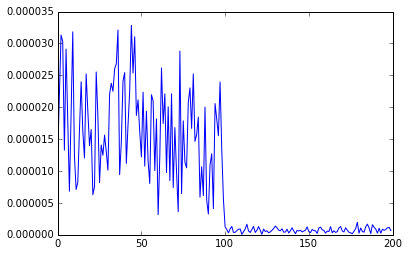

In [10]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp1["x_grad_fn"]) )

* Do the same thing but train an MLP (one hidden layer, with 100 hidden units)
* Evaluate accuracy
* Evaluate gradient plots for the input layer and the hidden layer

In [167]:
def mlp(X_data, y_data, num_hidden_units=None, lamb=0.0):
    # prototype
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    outputs = get_output([a_hidden, a_out], X)
    #print outputs
    loss = categorical_crossentropy( outputs[1], y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    
    """
    params = [W1, b1, W1, b1], so
    params[0], params[2] = W1, W2
    """
    W1_mask = theano.shared(
        np.ones( params[0].get_value().shape ).astype("float32") )
    W2_mask = theano.shared(
        np.ones( params[2].get_value().shape ).astype("float32") ) 
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    updates[ updates.keys()[0] ] = updates[ updates.keys()[0] ] * W1_mask
    updates[ updates.keys()[2] ] = updates[ updates.keys()[2] ] * W2_mask    
    
    train_fn = theano.function([X, y], loss, updates=updates)
    #Compute dLoss / dX
    x_grad_fn = theano.function([X, y], theano.gradient.subgraph_grad(cost=loss, wrt=[X], end=[X])[0][0])
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    #Compute dLoss / dHidden
    hidden_grad_fn = theano.function([X, y],
            theano.subgraph_grad(cost=loss, wrt=[ outputs[0] ], end=[X])[0][0])
    hidden_predict_fn = theano.function([X], outputs[0])
    #Compute dLoss / dW1
    w1_grad_fn = theano.function([X,y], T.grad(loss,params[0]))
    w2_grad_fn = theano.function([X,y], T.grad(loss,params[2]))
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "hidden_grad_fn":hidden_grad_fn,
            "hidden_predict_fn":hidden_predict_fn,
            "w1_grad_fn":w1_grad_fn,
            "w2_grad_fn":w2_grad_fn,
            "loss_fn": loss_fn,
            "W1_mask": W1_mask,
            "W2_mask": W2_mask,
            "W1": params[0],
            "W2": params[2]}

In [45]:
mlp2 = mlp(X_total, y_total, lamb=1e-4)

In [46]:
train_net(X_total, y_total, mlp2["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.19287630255
0.798047850244
0.650163044327
0.592531455304
0.566004271755
0.550285115026
0.540488815589
0.532426634981
0.52548010289
0.523098710172
0.517036588408
0.510581815446
0.507858662094
0.505045391862
0.501529487308
0.496382928538
0.494317369126
0.491174936635
0.487491684518
0.483392836779
0.481370312446
0.476039584351
0.472348474006
0.468698002244
0.46454991334
0.461459666196
0.456706158735
0.452557161329
0.447995996533
0.445969286798
0.439920116619
0.436065439093
0.432810955517
0.428084496305
0.4235590976
0.418587136857
0.412684866439
0.409588916592
0.403696744196
0.400020869492
0.396846357755
0.39145923888
0.384997870225
0.380787190717
0.375868475491
0.371643930481
0.365644132819
0.361878686949
0.356090822261
0.352943931611
0.348113484767
0.341537685697
0.338706170665
0.333842666532
0.329202192444
0.324482825074
0.319521077917
0.315487288137
0.31019618732
0.307993551252
0.30291905567
0.297659007081
0.29288364414
0.289406874806
0.28678713236
0.280932022017
0.278587167009
0.272

In [47]:
get_accuracy(X_total, y_total, mlp2["predict_fn"])

0.9999384312276813

In [51]:
mlp2["W2"].get_value().shape

(100, 4)

In [15]:
mlp2["x_grad_fn"](X_total, y_total).shape

(16242, 200)

Plot each feature $x_{i}$ against the average of $\frac{dL}{dx_{i}}$ over the entire dataset.

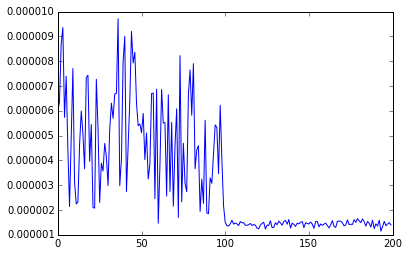

In [16]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp2["x_grad_fn"]) )

Plot each $h_{i}$ against the average of $\frac{dL}{dh_{i}}$ over the entire dataset.

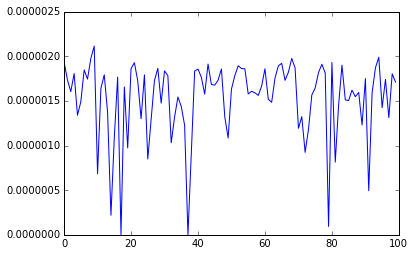

In [17]:
mlp2_hidden_grads = mlp2["hidden_grad_fn"](X_total, y_total)
plt.plot( np.mean(np.abs(mlp2_hidden_grads), axis=0) )

* Generate an MLP with no $L_{1}$ regularisation (we want to overfit the training set, and see how the validation set reacts).
* Let's train our network and after each epoch, save a plot of the (validation set) input and hidden gradients to disk.

In [18]:
%%bash
mkdir -p feature_ranking_out/input_grads
mkdir -p feature_ranking_out/hidden_grads

In [19]:
mlp3 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)

In [20]:
print_net(mlp3["net"])

(None, 200)
(None, 100)
(None, 4)
20504


Cut the data into training and validation.

In [21]:
idxs = [x for x in range(0, X_total.shape[0])]
random.shuffle(idxs)
train_idxs = idxs[0 : int(0.75*len(idxs))]
valid_idxs = idxs[int(0.75*len(idxs)) :: ]
Xt, yt, Xv, yv = X_total[train_idxs], y_total[train_idxs], X_total[valid_idxs], y_total[valid_idxs]

In [22]:
Xt.shape, yt.shape, Xv.shape, yv.shape

((12181, 200), (12181,), (4061, 200), (4061,))

In [23]:
def graph_grad_train(Xt, yt, Xv, yv, mlp, num_epochs=20, batch_size=128):
    
    hidden_grads_arr = []
    input_grads_arr = []
    
    idxs = [x for x in range(0, Xt.shape[0])]
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = mlp["train_fn"](
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        input_grads = mlp["x_grad_fn"](Xv, yv)
        input_grads = np.mean(np.abs(input_grads), axis=0)
        hidden_grads = mlp["hidden_grad_fn"](Xv, yv)
        np.savetxt("feature_ranking_out/hidden_grads/%s.csv" % str(epoch+1).zfill(2),
                   hidden_grads, delimiter=",", fmt="%5.5e")
        hidden_grads = np.mean(np.abs(hidden_grads), axis=0)   
        
        # save grads
        input_grads_arr.append(input_grads)
        hidden_grads_arr.append(hidden_grads)
        this_valid_loss = mlp["loss_fn"](Xv, yv)
        print "train loss, valid loss = %f, %f" % (np.mean(losses), this_valid_loss)
       
    print "plotting..."
    biggest_input_max = -1
    biggest_hidden_max = -1
    for i in range(0, len(hidden_grads_arr)):
        if np.max(hidden_grads_arr[i]) > biggest_hidden_max:
            biggest_hidden_max = np.max(hidden_grads_arr[i])
        if np.max(input_grads_arr[i]) > biggest_input_max:
            biggest_input_max = np.max(input_grads_arr[i])
            
    for epoch in range(0, num_epochs):
        plt.ylim(0, biggest_hidden_max)
        plt.plot(hidden_grads_arr[epoch])
        plt.savefig("feature_ranking_out/hidden_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()
        plt.ylim(0, biggest_input_max)
        plt.plot(input_grads_arr[epoch])
        plt.savefig("feature_ranking_out/input_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()

In [24]:
graph_grad_train(Xt, yt, Xv, yv, mlp3, num_epochs=100)

train loss, valid loss = 1.259534, 1.084590
train loss, valid loss = 0.921809, 0.820552
train loss, valid loss = 0.718729, 0.691864
train loss, valid loss = 0.629907, 0.631205
train loss, valid loss = 0.589884, 0.624609
train loss, valid loss = 0.566590, 0.605955
train loss, valid loss = 0.546265, 0.567964
train loss, valid loss = 0.536979, 0.577164
train loss, valid loss = 0.525036, 0.558745
train loss, valid loss = 0.516314, 0.570329
train loss, valid loss = 0.515275, 0.554276
train loss, valid loss = 0.505661, 0.545663
train loss, valid loss = 0.502044, 0.546647
train loss, valid loss = 0.499705, 0.564793
train loss, valid loss = 0.498049, 0.550870
train loss, valid loss = 0.491057, 0.549059
train loss, valid loss = 0.483071, 0.560452
train loss, valid loss = 0.481704, 0.556206
train loss, valid loss = 0.477753, 0.545201
train loss, valid loss = 0.476040, 0.549429
train loss, valid loss = 0.471631, 0.541363
train loss, valid loss = 0.468444, 0.610003
train loss, valid loss = 0.46377

In [27]:
get_accuracy(Xt, yt, mlp3["predict_fn"]), get_accuracy(Xv, yv, mlp3["predict_fn"])

(0.9831705114522618, 0.7658212262989411)

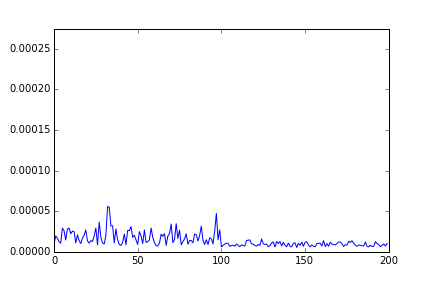

In [28]:
Image("feature_ranking_out/input_grads/01.png")

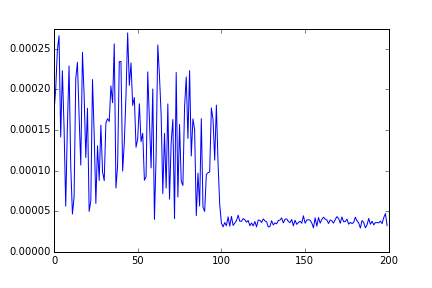

In [29]:
Image("feature_ranking_out/input_grads/99.png")

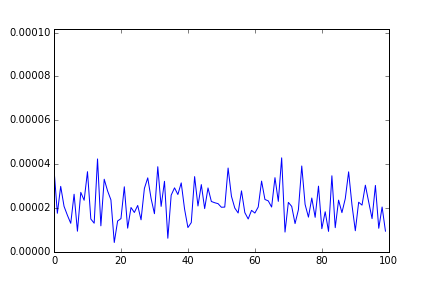

In [31]:
Image("feature_ranking_out/hidden_grads/01.png")

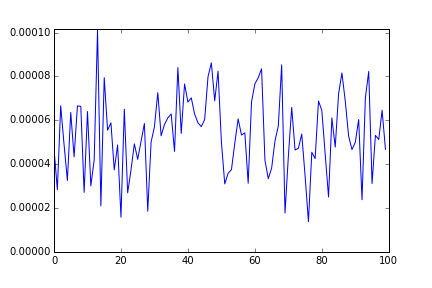

In [32]:
Image("feature_ranking_out/hidden_grads/99.png")

* Over time, the validation set gradients for input/hidden layers gets larger. Is this because the network is overfitting the training set, and hence the $\frac{dL}{dx}$ / $\frac{dL}{dh}$ has hit a local minimum, whereas this is not the case with the validation set?
* Let's look at the hidden activation gradients for the validation set, and sort them

In [33]:
mlp3_hidden_grads = mlp3["hidden_grad_fn"](Xv, yv)
mlp3_hidden_grads_mean = np.mean(np.abs(mlp3_hidden_grads), axis=0)
mlp3_hidden_grads_std = np.std(np.abs(mlp3_hidden_grads), axis=0)

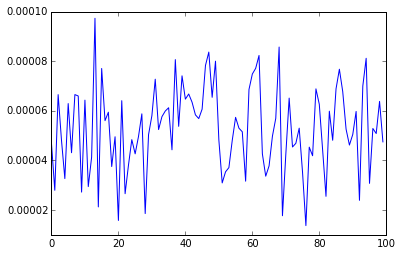

In [34]:
plt.plot(mlp3_hidden_grads_mean)

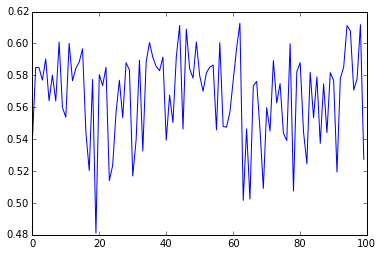

In [35]:
plt.plot(mlp3_hidden_grads_mean / mlp3_hidden_grads_std)

In [50]:
np.argsort(mlp3_hidden_grads_mean)

array([56, 11, 65, 84, 92,  0, 71, 77, 64,  7, 78, 60, 33, 63,  2, 28,  5,
       36, 73, 10,  8, 87, 35,  4, 67, 69, 79, 22, 90, 14, 55, 19, 59, 23,
        6, 62, 12, 99, 43, 42, 74, 83, 41,  3, 39, 91, 72, 13, 31, 47, 58,
       40, 76, 32, 34, 49, 81, 50, 75, 25, 95, 53, 38, 48, 17, 54, 88, 94,
       37, 51, 80, 96, 52, 82, 68, 24, 16, 66, 27, 15, 57, 97, 21,  9, 85,
       18,  1, 98, 26, 46, 89, 45, 30, 93, 86, 20, 44, 29, 70, 61])

In [94]:
np.argsort(mlp3_hidden_grads_mean / mlp3_hidden_grads_std)

array([12, 85, 74, 62, 77, 23, 26, 75,  6, 33, 78, 84, 97, 67, 34, 65, 21,
        3, 42, 90, 15,  9, 64, 20, 38, 66, 46, 54, 80, 41,  2, 89, 86, 52,
       61, 59, 60, 16, 36, 87, 57, 31, 69, 49, 98, 10, 50, 95, 51, 17, 58,
       19, 13, 82, 93, 43, 48, 94, 22,  1, 30,  7, 11, 28, 37, 53, 32, 70,
       71,  5, 44, 40, 96, 29, 25, 99, 81, 47, 14, 76, 83,  0, 91, 73, 56,
       88, 72, 63, 55, 35, 68, 24, 92, 39, 27, 79,  4,  8, 45, 18])

In [105]:
mlp3["net"].input_layer.W.get_value()[:,12].shape

(200,)

* For each hidden unit $h_{i}$, compute a histogram of the gradient $\frac{dL}{dh_{i}}$ on all the examples in the validation set.

In [36]:
%%bash
mkdir mlp3_each_unit_hidden_grads

mkdir: mlp3_each_unit_hidden_grads: File exists


In [42]:
mlp3["net"].input_layer.num_units

100

In [37]:
for i in range(0, mlp3["net"].input_layer.num_units):
    plt.hist( mlp3["hidden_grad_fn"](Xv, yv)[:,i] )
    plt.savefig("mlp3_each_unit_hidden_grads/%s.png" % str(i+1).zfill(2))
    plt.close()

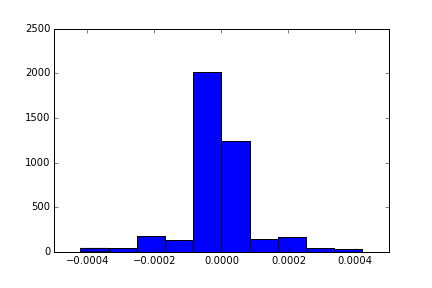

In [38]:
Image("mlp3_each_unit_hidden_grads/01.png")

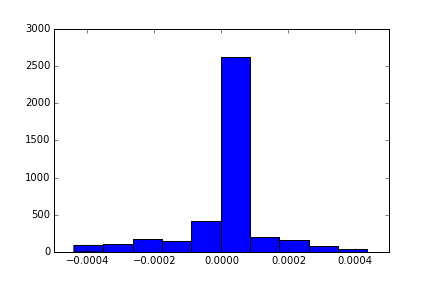

In [39]:
Image("mlp3_each_unit_hidden_grads/99.png")

* Train on all minibatches
* Evaluate performance of hidden layer on validation set
* Find the M worst hidden units (i.e. the ones with high mean gradients on the validation set), and reinitialise their incoming weights (or kill their incoming + outgoing weights)

In [178]:
def adaptive_train(Xt, yt, Xv, yv, mlp, num_to_fix, check_every, 
                   batch_size, num_epochs=20, mode="re_init", 
                   print_out=True, debug=False, args={}):
    sampler = GlorotUniform()
    idxs = [x for x in range(0, Xt.shape[0])]
    train_fn = mlp["train_fn"]
    hidden_predict_fn = mlp["hidden_predict_fn"]
    hidden_grad_fn = mlp["hidden_grad_fn"]
    w1_grad_fn = mlp["w1_grad_fn"]
    net = mlp["net"]
    h_grads_arr = []
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        if num_to_fix > 0:
            h_grads = hidden_grad_fn(Xv, yv)
            h_grads_mean = np.mean(np.abs(h_grads), axis=0)
            h_grads_std = np.std(np.abs(h_grads), axis=0)
            h_grads = h_grads_mean / h_grads_std
            # we get nans for killed units
            h_grads = np.nan_to_num(h_grads)
            # if a hidden unit has a big gradient but has already
            # been killed, then it will become zero
            h_idxs = np.argsort(h_grads)[::-1]
            #if debug:
            #    print h_grads
        #print "units to fix: %s" % str(h_idxs[0:num_to_fix])
        if num_to_fix > 0 and (epoch+1) % check_every == 0:
            if debug:
                print "hidden units to kill: %s" % str(h_idxs[0:num_to_fix])
                print "alive hidden units so far: %i" % len(killed_so_far.nonzero()[0])              
            if mode in ["kill_neuron", "re_init"]:
                for idx in h_idxs[0:num_to_fix]:
                    W1, W2 = mlp["W1"].get_value(), mlp["W2"].get_value()
                    W1_mask, W2_mask = mlp["W1_mask"].get_value(), mlp["W2_mask"].get_value()
                    if mode == "kill_neuron":
                        # kill the incoming weights
                        W1[:, idx] = np.zeros( (W1[:, idx].shape[0], 1) ).flatten()
                        W1_mask[:, idx] = np.zeros( (W1_mask[:, idx].shape[0], 1) ).flatten()
                        # kill the outgoing weights
                        W2[idx, :] = np.zeros( (W2[idx, :].shape[0], 1) ).flatten()
                        W2_mask[idx, :] = np.zeros( (W2_mask[idx, :].shape[0], 1) ).flatten()
                        # set the matrices
                        mlp["W1"].set_value(W1)
                        mlp["W1_mask"].set_value(W1_mask)
                        mlp["W2"].set_value(W2)
                        mlp["W2_mask"].set_value(W2_mask)
                    elif mode == "re_init":
                        W1[:,idx] = sampler.sample( ( W1[:,idx].shape[0], 1) ).flatten()
                        # TODO: lower the outgoing weights by a factor
                        if "re_init_scale" in args:
                            #print "reinit"
                            W2[idx,:] = W2[idx,:] * args["re_init_scale"]
                            mlp["W2"].set_value(W2)
                        mlp["W1"].set_value(W1)
            elif mode in ["kill_weight"]:
                W1, W2 = mlp["W1"].get_value(), mlp["W2"].get_value()
                W1_mask, W2_mask = mlp["W1_mask"].get_value(), mlp["W2_mask"].get_value()
                # get dLoss/dh for all hidden units, flatten, and multiply
                # with W1 mask so we don't get connections we already killed
                sorted_mat = np.argsort(
                    np.abs(w1_grad_fn(Xv, yv).flatten()) * W1_mask.flatten() 
                )
                # argsort matrix
                sorted_mat_idxs = np.dstack(
                    np.unravel_index(sorted_mat, W1.shape) )[0][::-1]
                for tp in sorted_mat_idxs[0:num_to_fix]:
                    W1[ tp[0], tp[1] ] = 0
                    W1_mask[ tp[0], tp[1] ] = 0
                mlp["W1_mask"].set_value(W1_mask)
                mlp["W1"].set_value(W1)                 
            else:
                raise NotImplementedException()
        if print_out:
            print np.mean(losses)
    return h_grads_arr

In [108]:
mlp_["W2"].get_value().zero()

AttributeError: 'numpy.ndarray' object has no attribute 'zero'

In [181]:
for re_init_scale in [0.01]:
    for check_every in [1, 20]:
        rows_to_write = []
        for num_to_fix in [0, 5, 10, 20, 40, 80]:
            valid_accs = []
            for x in range(0, 10):
                row = [num_to_fix, x]
                np.random.seed(x)
                random.seed(x)
                mlp_ = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
                h_grads_arr = adaptive_train(Xt, yt, Xv, yv, mlp_, 
                    batch_size=128, num_epochs=100, num_to_fix=num_to_fix,
                    check_every=check_every, print_out=False, mode="re_init",
                    args={"re_init_scale": re_init_scale}
                )
                valid_acc = get_accuracy(Xv, yv, mlp_["predict_fn"])
                row.append(valid_acc)
                valid_accs.append(valid_acc)
                rows_to_write.append(row)
                print row
        with open("feature_ranking_out_adaptive/stats%i_%f.csv" % (check_every, re_init_scale), "wb") as f:
            f.write("num_to_fix,seed,valid_accuracy\n")
            for row in rows_to_write:
                f.write(",".join( [str(r) for r in row] ) + "\n")

[0, 0, 0.7424279734055651]
[0, 1, 0.7485840925880325]
[0, 2, 0.7648362472297464]
[0, 3, 0.7475991135188377]
[0, 4, 0.7500615611918247]
[0, 5, 0.7672986949027333]
[0, 6, 0.7537552327013051]
[0, 7, 0.758680128047279]
[0, 8, 0.7653287367643438]
[0, 9, 0.7596651071164737]
[5, 0, 0.7729623245506033]
[5, 1, 0.7692686530411229]
[5, 2, 0.7668062053681359]
[5, 3, 0.7655749815316425]
[5, 4, 0.7559714356069933]
[5, 5, 0.7766559960600837]
[5, 6, 0.7685299187392268]
[5, 7, 0.7702536321103176]
[5, 8, 0.7623737995567594]
[5, 9, 0.7596651071164737]
[10, 0, 0.767544939670032]
[10, 1, 0.764343757695149]
[10, 2, 0.7771484855946811]
[10, 3, 0.7392267914306822]
[10, 4, 0.7749322826889928]
[10, 5, 0.7589263728145776]
[10, 6, 0.7685299187392268]
[10, 7, 0.718295986210293]
[10, 8, 0.7621275547894607]
[10, 9, 0.7680374292046294]
[20, 0, 0.778872198965772]
[20, 1, 0.7825658704752524]
[20, 2, 0.7916769268653041]
[20, 3, 0.7776409751292785]
[20, 4, 0.6350652548633342]
[20, 5, 0.7833046047771485]
[20, 6, 0.7820733

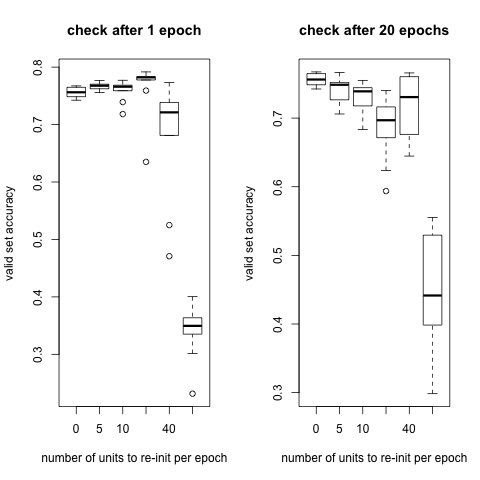

In [182]:
%%R
par(mfrow=c(1,2))
files = c(
    "feature_ranking_out_adaptive/stats1_0.010000.csv",
    "feature_ranking_out_adaptive/stats20_0.010000.csv"
)
captions = c(
    "check after 1 epoch",
    "check after 20 epochs"
)
for( i in 1:length(files)) {
    df = read.csv( files[i] )
    boxplot(valid_accuracy ~ num_to_fix, data=df, main=captions[i],
            xlab="number of units to re-init per epoch", ylab="valid set accuracy")
}

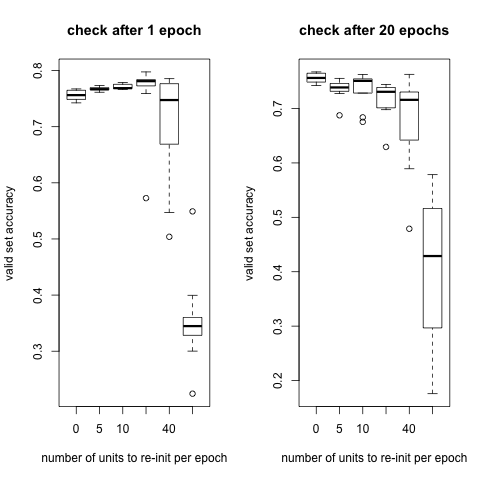

In [180]:
%%R
par(mfrow=c(1,2))
files = c(
    "feature_ranking_out_adaptive/stats1_0.100000.csv",
    "feature_ranking_out_adaptive/stats20_0.100000.csv"
)
captions = c(
    "check after 1 epoch",
    "check after 20 epochs"
)
for( i in 1:length(files)) {
    df = read.csv( files[i] )
    boxplot(valid_accuracy ~ num_to_fix, data=df, main=captions[i],
            xlab="number of units to re-init per epoch", ylab="valid set accuracy")
}

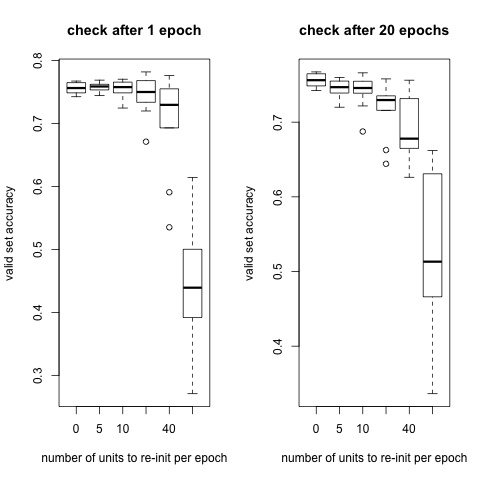

In [81]:
%%R
par(mfrow=c(1,2))
files = c(
    "feature_ranking_out_adaptive/stats1.csv",
    "feature_ranking_out_adaptive/stats20.csv"
)
captions = c(
    "check after 1 epoch",
    "check after 20 epochs"
)
for( i in 1:length(files)) {
    df = read.csv( files[i] )
    boxplot(valid_accuracy ~ num_to_fix, data=df, main=captions[i],
            xlab="number of units to re-init per epoch", ylab="valid set accuracy")
}

In [141]:
100/20

5

It doesn't look like the weight reinitialisation trick works?

Let's do the version but with neuron killing. We're training for 100 epochs, so:
* When $checkEvery=5$

In [146]:
for check_every in [5, 20]:
    rows_to_write = []
    for num_to_fix in [1, 2, 3]:
        valid_accs = []
        # row in the format "num_to_fix,seed,valid_acc
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp_ = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(
                Xt, yt, Xv, yv, mlp_, 
                batch_size=128, 
                num_epochs=100, 
                num_to_fix=num_to_fix, 
                check_every=check_every, 
                print_out=False,
                kill_neuron=True)
            valid_acc = get_accuracy(Xv, yv, mlp_["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row
    with open("feature_ranking_out_adaptive/kill_stats%i.csv" % check_every, "wb") as f:
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

[0, 0, 0.7424279734055651]
[0, 1, 0.7485840925880325]
[0, 2, 0.7648362472297464]
[0, 3, 0.7475991135188377]
[0, 4, 0.7500615611918247]
[0, 5, 0.7672986949027333]
[0, 6, 0.7537552327013051]
[0, 7, 0.758680128047279]
[0, 8, 0.7653287367643438]
[0, 9, 0.7596651071164737]
[0, 0, 0.7424279734055651]
[0, 1, 0.7485840925880325]
[0, 2, 0.7648362472297464]
[0, 3, 0.7475991135188377]
[0, 4, 0.7500615611918247]
[0, 5, 0.7672986949027333]
[0, 6, 0.7537552327013051]
[0, 7, 0.758680128047279]
[0, 8, 0.7653287367643438]
[0, 9, 0.7596651071164737]


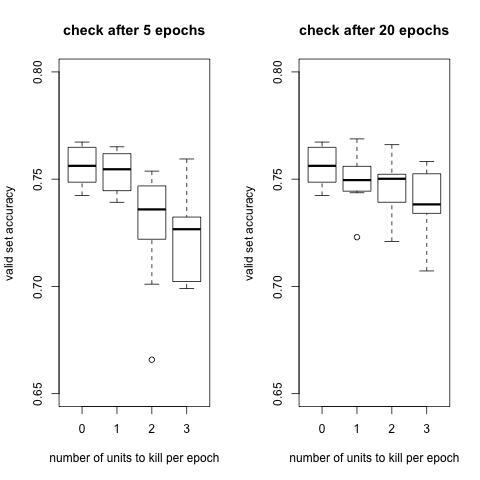

In [149]:
%%R
par(mfrow=c(1,2))
files = c(
    "feature_ranking_out_adaptive/kill_stats5.csv",
    "feature_ranking_out_adaptive/kill_stats20.csv"
)
captions = c(
    "check after 5 epochs",
    "check after 20 epochs"
)
for( i in 1:length(files)) {
    df = read.csv( files[i] )
    boxplot(valid_accuracy ~ num_to_fix, data=df, main=captions[i], ylim=c(0.65,0.80),
            xlab="number of units to kill per epoch", ylab="valid set accuracy")
}

From this figure it appears that killing hidden units (i.e. their incoming and outcoming weights) does not seem to be of a benefit either. The only "nice" thing is that on the left figure, killing 1 unit per 5 epochs achieves a very similar validation set accuracy distribution to the baseline.

In [150]:
for check_every in [1]:
    rows_to_write = []
    for num_to_fix in [1]:
        valid_accs = []
        # row in the format "num_to_fix,seed,valid_acc
        for x in range(0, 1):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp_ = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(
                Xt, yt, Xv, yv, mlp_, 
                batch_size=128, 
                num_epochs=100, 
                num_to_fix=num_to_fix, 
                check_every=check_every, 
                print_out=False,
                kill_neuron=True,
                debug=True)

hidden units to kill: [54]
alive hidden units so far: 100
hidden units to kill: [22]
alive hidden units so far: 99
hidden units to kill: [37]
alive hidden units so far: 98
hidden units to kill: [25]
alive hidden units so far: 97
hidden units to kill: [91]
alive hidden units so far: 96
hidden units to kill: [33]
alive hidden units so far: 95
hidden units to kill: [48]
alive hidden units so far: 94
hidden units to kill: [5]
alive hidden units so far: 93
hidden units to kill: [4]
alive hidden units so far: 92
hidden units to kill: [64]
alive hidden units so far: 91
hidden units to kill: [27]
alive hidden units so far: 90
hidden units to kill: [10]
alive hidden units so far: 89
hidden units to kill: [68]
alive hidden units so far: 88
hidden units to kill: [39]
alive hidden units so far: 87
hidden units to kill: [85]
alive hidden units so far: 86
hidden units to kill: [70]
alive hidden units so far: 85
hidden units to kill: [99]
alive hidden units so far: 84
hidden units to kill: [92]
alive

In [555]:
for i in range(0, len(h_grads_arr)):
    plt.ylim(0, 0.000050)
    plt.plot(h_grads_arr[i])
    plt.savefig("feature_ranking_out_adaptive/%s.png" % str(i+1).zfill(2))
    plt.close()

Let's try the third idea and kill incoming weights for the hidden units. This seems like the less ruthless approach out of the three.

In [173]:
for check_every in [1, 20]:
    rows_to_write = []
    for num_to_fix in [5, 10, 20, 40, 80]:
        valid_accs = []
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp_ = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(Xt, yt, Xv, yv, mlp_, 
                batch_size=128, num_epochs=100, num_to_fix=num_to_fix, check_every=check_every, print_out=False,
                mode="kill_weight")
            valid_acc = get_accuracy(Xv, yv, mlp_["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row
        print "num killed connections: %f" % (np.sum(mlp_["W1"].get_value() == 0))
    with open("feature_ranking_out_adaptive_weights/stats%i.csv" % check_every, "wb") as f: #wb
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

[5, 0, 0.7508002954937207]
[5, 1, 0.7591726175818764]
[5, 2, 0.7613888204875646]
[5, 3, 0.7569564146761881]
[5, 4, 0.7532627431667077]
[5, 5, 0.7670524501354347]
[5, 6, 0.7579413937453829]
[5, 7, 0.7567101699088894]
[5, 8, 0.7714848559468112]
[5, 9, 0.7567101699088894]
num killed connections: 500.000000
[10, 0, 0.7604038414183698]
[10, 1, 0.7658212262989411]
[10, 2, 0.7680374292046294]
[10, 3, 0.7581876385126816]
[10, 4, 0.7564639251415908]
[10, 5, 0.7665599606008372]


KeyboardInterrupt: 

In [166]:
mlp_["w1_grad_fn"](Xv, yv)

array([[  1.93302076e-04,  -1.23520691e-04,   1.26505594e-05, ...,
         -1.97063139e-05,   6.46673233e-05,   2.54514350e-04],
       [ -1.57708877e-04,  -2.76175558e-05,  -4.28745646e-05, ...,
          1.88469595e-04,   2.87798694e-05,   1.45041833e-04],
       [  1.45680204e-04,  -2.36857567e-05,   1.63664870e-04, ...,
         -9.50842868e-05,   6.12528267e-05,   5.75790254e-05],
       ..., 
       [ -1.87937040e-03,   1.12496885e-03,  -1.87185940e-03, ...,
          5.62782044e-04,  -7.62666422e-04,   1.57828596e-03],
       [ -1.07122718e-03,  -6.70942182e-04,  -1.17461189e-03, ...,
          2.22159315e-03,   2.68011479e-04,   1.28876223e-03],
       [  1.05016781e-04,  -2.02715683e-04,  -4.62873580e-04, ...,
          1.40090220e-03,  -1.67967581e-04,   8.59741579e-04]])

----

* Plot the gradients on MNIST digits. This makes a nice visualisation which could make it into the paper.

In [380]:
sys.path.append("../modules/")
import helper as hp

In [381]:
mnist_train_set, _, _ = hp.load_mnist()

In [387]:
mnist_x, mnist_y = mnist_train_set
mnist_x = mnist_x.astype("float32")
mnist_y = mnist_y.astype("int32")

In [383]:
def simple_conv(X_data, y_data):
    a_in = InputLayer( (None, 1, 28, 28 ) )
    a_conv1 = Conv2DLayer(a_in, num_filters=16, filter_size=(5,5), nonlinearity=rectify)
    a_mp1 = MaxPool2DLayer(a_conv1, pool_size=(2,2))
    a_conv2 = Conv2DLayer(a_mp1, num_filters=32, filter_size=(5,5), nonlinearity=rectify)
    a_mp2 = MaxPool2DLayer(a_conv2, pool_size=(2,2))
    a_out = DenseLayer(a_mp2, num_units=np.max(y_data)+1, nonlinearity=softmax)  
    X = T.tensor4('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean()
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [384]:
conv = simple_conv(mnist_x, mnist_y)

In [388]:
train_net(mnist_x, mnist_y, conv["train_fn"], num_epochs=5, batch_size=64)

0.26089267387
0.0771458087307
0.0571138216773


KeyboardInterrupt: 

In [393]:
mnist_x_9 = mnist_x[ (mnist_y == 9) ]
mnist_y_9 = np.asarray([9 for x in range(0, mnist_x_9.shape[0])], dtype="int32")

In [394]:
grads_for_9 = conv["x_grad_fn"](mnist_x_9, mnist_y_9)

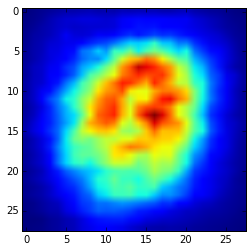

In [403]:
plt.imshow( np.mean(np.abs(grads_for_9),axis=0)[0] )

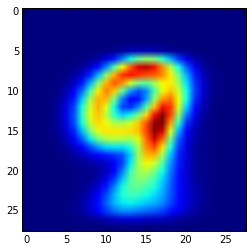

In [404]:
plt.imshow( np.mean(np.abs(mnist_x_9),axis=0)[0] )

----

* Not using autoencoders, because the noise attributes actually get larger gradients. Because they have no structure to them, the network allocates more capacity to them, and hence they end up being more important attributes.

----

I suspect that getting rid of neurons is a bit too ruthless and that we need to get rid of individual weight connections instead...

In [421]:
def mlp_weights(X_data, y_data, num_hidden_units=None, lamb=0.0):
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    print "debug params: %s" % str(params)
    # create the masks
    W1_mask = theano.shared(
        np.ones( mlp6["params"][0].get_value().shape ).astype("float32") )
    W2_mask = theano.shared(
        np.ones( mlp6["params"][2].get_value().shape ).astype("float32") )
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    # W1
    updates[ updates.keys()[0] ] = updates[ updates.keys()[0] ] * W1_mask
    # W2
    updates[ updates.keys()[2] ] = updates[ updates.keys()[2] ] * W2_mask
    
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss ) 
    # [W1, b1, W2, b2]
    grad_fn = theano.function([X,y], T.grad(loss,params)[0])
    
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn,
            "grad_fn": grad_fn,
            "W1_mask": W1_mask,
            "W2_mask": W2_mask,
            "loss": loss,
            "params": params,
            "updates": updates}

In [206]:
mlp5 = mlp_weights(X_total, y_total)
#mlp5["net"].W.set_value( np.zeros( mlp5["net"].W.get_value().shape ) )
#mlp5["net"].input_layer.W.set_value( np.zeros( mlp5["net"].input_layer.W.get_value().shape ) )

In [216]:
train_net(Xt, yt, mlp5["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

0.498152009246
0.494480421681
0.487800148276
0.484657040547
0.484245727927
0.475663009436
0.472413697956
0.467532039505
0.461597414646
0.45953481833
0.453844758196
0.45038948606
0.446368459349
0.442047243577
0.435174076259
0.431614124761
0.426534368187
0.421506970681
0.417738618038
0.413633560957
0.405006923479
0.403783977573
0.399962268693
0.3909470268
0.385232945859
0.379520955028
0.374773443025
0.366748786757
0.362927392314
0.355000048142
0.351915522134
0.344298361191
0.339608609715
0.33470379973
0.328901171846
0.324982808321
0.317446649845
0.31165082214
0.30586209336
0.300938004301
0.294374141028
0.289602712949
0.284772042848
0.277769599244
0.276351784064
0.269639783459
0.261089588105
0.257645861205
0.252326469186
0.247450087247
0.244095418357
0.237265945739
0.232367901905
0.226933876074
0.222551226471
0.219835025699
0.21674171732
0.214428106249
0.203094139347
0.201901537843
0.199503463065
0.19205762097
0.186776063846
0.181878853464
0.176922942236
0.175255520618
0.171028089359
0.16

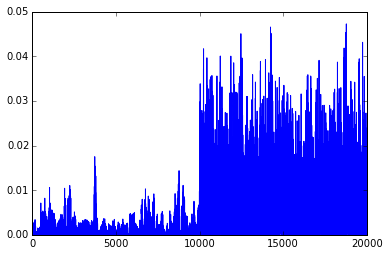

In [219]:
plt.plot(np.abs(mlp5["grad_fn"](Xv, yv).flatten()))

In [441]:
def adaptive_train_weights(Xt, yt, Xv, yv, mlp, num_to_fix, check_every, 
                   batch_size, num_epochs=20, kill_weights=True, print_out=True):
    sampler = GlorotUniform()
    idxs = [x for x in range(0, Xt.shape[0])]
    net, train_fn, grad_fn = mlp["net"], mlp["train_fn"], mlp["grad_fn"]
    W1_mask = mlp["W1_mask"]
    w1_grads_arr = []
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        #print "units to fix: %s" % str(h_idxs[0:num_to_fix])
        if num_to_fix > 0 and (epoch+1) % check_every == 0:
            this_W1_mask = W1_mask.get_value()
            # get dL/dW1 on the validation set
            sorted_mat = np.argsort( np.abs(grad_fn(Xv, yv).flatten()) * this_W1_mask.flatten() )
            w1_grads_arr.append(sorted_mat)
            # argsort matrix
            sorted_mat_idxs = np.dstack(
                np.unravel_index(sorted_mat, net.input_layer.W.get_value().shape) )[0][::-1]
            W = net.input_layer.W.get_value()
            for tp in sorted_mat_idxs[0:num_to_fix]:
                if kill_weights:
                    W[ tp[0], tp[1] ] = 0
                    this_W1_mask[ tp[0], tp[1] ] = 0
                else:
                    W[ tp[0], tp[1] ] = sampler.sample( (1,1) ).flatten()
            W1_mask.set_value(this_W1_mask)
            net.input_layer.W.set_value(W)
            #print np.sum(W==0.0), np.sum(this_W1_mask==0.0)
        if print_out:
            print np.mean(losses)
    return w1_grads_arr

In [440]:
for check_every in [1]:
    rows_to_write = []
    for num_to_fix in [1, 5, 10, 20, 40]: #1,5
        valid_accs = []
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp5 = mlp_weights(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train_weights(Xt, yt, Xv, yv, mlp5, 
                batch_size=128, num_epochs=100, num_to_fix=num_to_fix, check_every=check_every, print_out=False)
            print "num killed connections: %f" % (np.sum(mlp5["net"].input_layer.W.get_value() == 0))
            valid_acc = get_accuracy(Xv, yv, mlp5["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row
    with open("feature_ranking_out_adaptive_weights/stats%i.csv" % check_every, "wb") as f: #wb
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 0, 0.7692686530411229]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 1, 0.7616350652548634]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 2, 0.7640975129278503]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 3, 0.7648362472297464]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 4, 0.7722235902487072]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 5, 0.7569564146761881]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 6, 0.7618813100221621]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 7, 0.7579413937453829]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 8, 0.7508002954937207]
debug params: [W, b, W, b]
num killed connections: 1000.000000
[10, 9, 0.7631125338586555]
debug params: [W, b, W, b]
num killed connections: 2000.000000
[20, 0, 0.7719773454814085]

In [429]:
np.sum( mlp5["net"].input_layer.W.get_value() == 0 )

8

In [254]:
sorted_mat = np.argsort(np.abs(mlp5["grad_fn"](Xv, yv).flatten()))



#np.argsort(mlp5["grad_fn"](Xv, yv).flatten()).reshape( mlp5["net"].input_layer.W.get_value().shape)

In [261]:
sorted_mat_idxs = np.dstack( np.unravel_index(sorted_mat, mlp5["net"].input_layer.W.get_value().shape) )[0][::-1]

In [257]:
np.max( np.abs(mlp5["grad_fn"](Xv, yv)) ), np.min( np.abs(mlp5["grad_fn"](Xv, yv) ) ) 

(0.047240316424077028, 0.0)

In [276]:
?mlp5["net"].W.set_value

In [272]:
mlp5["grad_fn"](Xv, yv)[ sorted_mat_idxs[0][0], sorted_mat_idxs[0][1] ]

0.047240316424077028

In [265]:
mlp5["grad_fn"](Xv, yv).shape

(200, 100)

In [204]:
plt.plot( np.abs(mlp5["tmp_fn"](Xv, yv)).flatten() )

KeyError: 'tmp_fn'

In [319]:
test_dict = sgd(mlp5["loss"], mlp5["params"], 0.01)
test_dict

OrderedDict([(W, Elemwise{sub,no_inplace}.0),
             (b, Elemwise{sub,no_inplace}.0),
             (W, Elemwise{sub,no_inplace}.0),
             (b, Elemwise{sub,no_inplace}.0)])

In [328]:
test_dict[ test_dict.keys()[0] ] * np.ones( mlp5["params"][0].get_value().shape )

Elemwise{mul,no_inplace}.0

In [360]:
mlp5["grads"][0]

KeyError: 'grads'

In [388]:
mlp6 = mlp_weights(Xt, yt, lamb=0)

debug params: [W, b, W, b]
debug grads: [dot.0, DimShuffle{1}.0, Elemwise{add,no_inplace}.0, DimShuffle{1}.0]


In [408]:
mlp6["updates"]

OrderedDict([(W, Elemwise{add,no_inplace}.0),
             (b, Elemwise{add,no_inplace}.0),
             (W, Elemwise{add,no_inplace}.0),
             (b, Elemwise{add,no_inplace}.0),
             (<TensorType(float64, matrix)>, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, vector)>, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, matrix)>, Elemwise{sub,no_inplace}.0),
             (<TensorType(float64, vector)>, Elemwise{sub,no_inplace}.0)])

In [383]:
mlp6["W1_mask"].set_value( mlp6["W1_mask"].get_value()*0 )
mlp6["W1_mask"].get_value()

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ..., 
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

In [384]:
mlp6["net"].input_layer.W.get_value()

array([[ 0.05470818,  0.02120683,  0.07059879, ...,  0.09436997,
        -0.09669261, -0.10973032],
       [-0.0517125 , -0.11202686,  0.08334102, ...,  0.0942083 ,
        -0.10220168, -0.0606113 ],
       [ 0.07471082, -0.08856105,  0.09389722, ...,  0.04164411,
         0.01324239,  0.00816825],
       ..., 
       [ 0.05871566, -0.12756718,  0.07058836, ..., -0.06776465,
        -0.01413079, -0.00808478],
       [-0.00871159,  0.1008104 , -0.13568771, ...,  0.10167564,
        -0.02167538, -0.06554889],
       [-0.13245182, -0.10813265,  0.13434869, ..., -0.09897702,
         0.12640046,  0.13643417]])

In [385]:
train_net(Xt, yt, mlp6["train_fn"], num_epochs=10, batch_size=32)

1.28684574926
1.19193620066
1.15416646592
1.12744048373
1.1059697712
1.08744226336
1.07423088581
1.0612520737
1.05100869261
1.04436850967
